In [2]:
import os
import pandas as pd
import ptitprince as pt
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
import arviz as az
from systole.detection import oxi_peaks, rr_artefacts

sns.set_context('talk')

Import merged dataframe from behavioral data.

In [3]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
merged_df = pd.read_csv(path + '/data/merged.txt')
merged_df = merged_df[merged_df.Session == 'Del1']

Filter trial level dataframe, discretize confidence rating and store results in a `metacognition_trials.txt` file.

In [13]:
metacognition_df = pd.DataFrame([])
drop = []
for sub in merged_df.Subject.unique():
    for cond in merged_df.Modality.unique():
        this_df = merged_df[(merged_df.Subject==sub) & (merged_df.Modality==cond)]
        
        # Drop NAs
        this_df = this_df[~this_df.Confidence.isnull()]

        # Discretize ratings
        try:
            new_ratings, out = discreteRatings(this_df.Confidence.to_numpy(), verbose=False)
            this_df.loc[:, 'Confidence'] = new_ratings
            metacognition_df = metacognition_df.append(this_df[['Subject', 'Modality', 'Alpha', 'Estimation', 'Confidence']])

        except ValueError:
            print(f'Dropping subject {sub} due to invalid ratings')
            drop.append(sub)

for sub in drop:
    metacognition_df = metacognition_df[metacognition_df.Subject!=sub]

metacognition_df.columns = ['Subject', 'Condition', 'Stimuli', 'Estimation', 'Confidence']
metacognition_df.loc[:, 'Stimuli'] = metacognition_df['Stimuli'] > 0
metacognition_df.loc[:, 'Estimation'] = metacognition_df['Estimation'] == 'More'
metacognition_df['Accuracy'] = (metacognition_df['Stimuli'] & metacognition_df['Estimation']) | (~metacognition_df['Stimuli'] & ~metacognition_df['Estimation'])

metacognition_df.to_csv(path + '/data/metacognition_trials.txt')

Dropping subject sub_0245 due to invalid ratings


In [14]:
sdt_df = pd.DataFrame([])
to_R_df = pd.DataFrame([])
for sub in metacognition_df.Subject.unique():
    for cond in metacognition_df.Condition.unique():
        this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Condition==cond)]
        
        nR_S1, nR_S2 = trials2counts(
            data=this_df, stimuli='Stimuli', accuracy='Accuracy',
            confidence='Confidence', nRatings=4)
        nR_S1, nR_S2 = np.array(nR_S1), np.array(nR_S2)
        
        to_R_df = to_R_df.append(pd.DataFrame({'Subject': sub,
                                         'Condition': cond,
                                         'nR_S1': nR_S1,
                                         'nR_S2': nR_S2}))
        
        Tol = 1e-05
        nratings = int(len(nR_S1) / 2)

        # Adjust to ensure non-zero counts for type 1 d' point estimate
        adj_f = 1 / ((nratings) * 2)

        nR_S1_adj = nR_S1 + adj_f
        nR_S2_adj = nR_S2 + adj_f

        ratingHR, ratingFAR = [], []
        for c in range(1, int(nratings * 2)):
            ratingHR.append(sum(nR_S2_adj[c:]) / sum(nR_S2_adj))
            ratingFAR.append(sum(nR_S1_adj[c:]) / sum(nR_S1_adj))

        d1 = dprime(ratingHR[nratings - 1], ratingFAR[nratings - 1])
        c1 = criterion(ratingHR[nratings - 1], ratingFAR[nratings - 1])
        
        sdt_df = sdt_df.append(pd.DataFrame({'Subject': [sub],
                                             'Condition': [cond],
                                             'Accuracy': this_df.Accuracy.to_numpy().mean() * 100,
                                             'd': [d1],
                                             'c': [c1]}))

In [15]:
to_R_df.to_csv('nRS.txt')

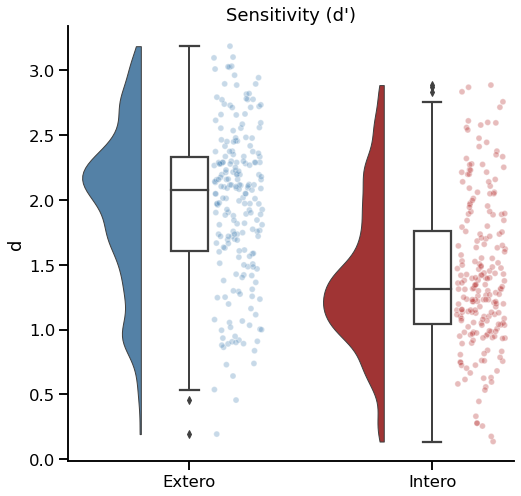

In [16]:
f, ax = plt.subplots(figsize=(8, 8))

ax = pt.RainCloud(x='Condition', y='d', data=sdt_df, palette=['steelblue', 'firebrick'], bw=.2,
                    move=.2, width_viol=.5, ax=ax, orient='v', rain_linewidth=1, point_size=6, rain_alpha=.3)
ax.set_title('Sensitivity (d\')')
ax.set_ylabel('d')
ax.set_xlabel('')
sns.despine()
plt.savefig(path + '/figures/Fig3_dprime.svg', dpi=600)

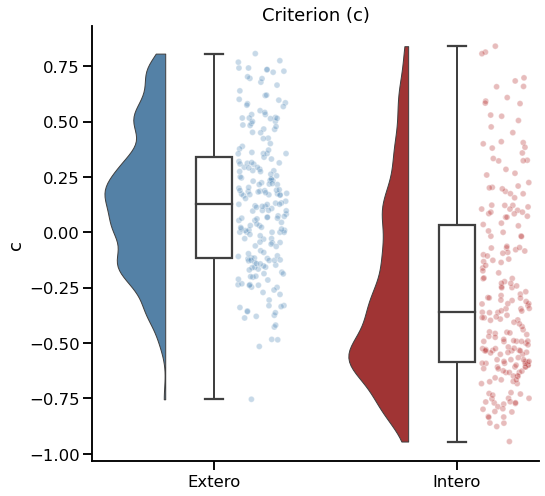

In [17]:
f, ax = plt.subplots(figsize=(8, 8))

ax = pt.RainCloud(x='Condition', y='c', data=sdt_df, palette=['steelblue', 'firebrick'], bw=.2,
                    move=.2, width_viol=.5, ax=ax, orient='v', rain_linewidth=1, point_size=6, rain_alpha=.3)
ax.set_title('Criterion (c)')
ax.set_ylabel('c')
ax.set_xlabel('')
sns.despine()
plt.savefig(path + '/figures/Fig3_criterion.svg', dpi=600)

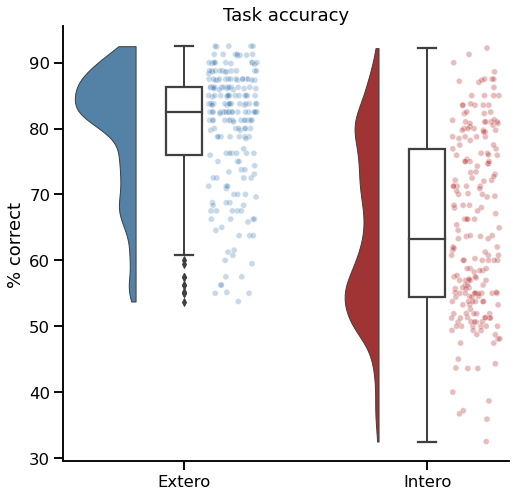

In [18]:
f, ax = plt.subplots(figsize=(8, 8))

ax = pt.RainCloud(x='Condition', y='Accuracy', data=sdt_df, palette=['steelblue', 'firebrick'], bw=.2,
                    move=.2, width_viol=.5, ax=ax, orient='v', rain_linewidth=1, point_size=6, rain_alpha=.3)
ax.set_title('Task accuracy')
ax.set_ylabel('% correct')
ax.set_xlabel('')
sns.despine()
plt.savefig(path + '/figures/Fig3_accuracy.svg', dpi=600)

# Raw confidence ratings

In [19]:
rawConfidence_df = pd.DataFrame([])
for sub in metacognition_df.Subject.unique():
    for cond in metacognition_df.Condition.unique():
        for corr in [True, False]:
            this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Condition==cond) & (metacognition_df.Accuracy==corr)]
            new_ratings = this_df.Confidence.to_numpy()
            rawConfidence_df = rawConfidence_df.append(pd.DataFrame({'Subject': sub,
                          'Condition': cond,
                          'Correct': corr,
                          'Ratings': np.arange(1, 5),
                          'Density': np.array([np.count_nonzero(new_ratings == i) for i in range(1, 5)]) / len(new_ratings)}), ignore_index=True)

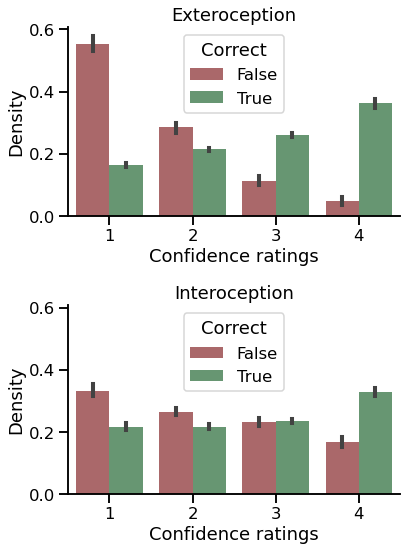

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharey=True)
#sns.stripplot(data=rawConfidence_df[rawConfidence_df.Condition=='Extero'], x='Ratings', y='Density', hue='Correct', ax=ax[0], palette=["#b55d60", "#5f9e6e"])
sns.barplot(data=rawConfidence_df[rawConfidence_df.Condition=='Extero'], x='Ratings', y='Density', hue='Correct', ax=ax[0], palette=["#b55d60", "#5f9e6e"])
ax[0].set_title('Exteroception')
ax[0].set_xlabel('Confidence ratings')

#sns.stripplot(data=rawConfidence_df[rawConfidence_df.Condition=='Intero'], x='Ratings', y='Density', hue='Correct', ax=ax[1], palette=["#b55d60", "#5f9e6e"])
sns.barplot(data=rawConfidence_df[rawConfidence_df.Condition=='Intero'], x='Ratings', y='Density', hue='Correct', ax=ax[1], palette=["#b55d60", "#5f9e6e"])
ax[1].set_title('Interoception')
ax[1].set_xlabel('Confidence ratings')
plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/rawConfidence.svg', dpi=300)

# Fitting hierarchical model using PyMC3

## Single subject fit

## Repeated measures model

Fitting metacognition model using `metadPy.hierarchical`. This can be long, you can skip this step and load the `.json` file to save time.

In [16]:
model_RM, trace_RM = hmetad(data=group_df, subject='Subject', stimuli='Stimuli',
                            accuracy='Accuracy', confidence='Confidence',
                            within='Condition', nRatings=4, tune=2000, cores=4)

Saving trace as `json` file for later use.

In [ ]:
idata_pymc3 = az.from_pymc3(trace)

Loading `.json` file.

In [166]:
idata_pymc3 = az.from_json(path + '/data/1way.json')

# PyMC3 Model visualization

In [167]:
az.summary(idata_pymc3, round_to=2, var_names=["mRatio", "tau"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mRatio[0,0,0]",1.25,0.24,0.79,1.59,0.05,0.04,21.81,21.81,26.12,286.95,1.10
"mRatio[0,0,1]",0.36,0.27,0.00,0.89,0.05,0.04,31.19,31.19,21.58,93.43,1.17
"mRatio[0,1,0]",1.12,0.46,0.45,1.91,0.18,0.13,6.78,6.78,6.16,41.44,1.43
"mRatio[0,1,1]",0.06,0.08,0.00,0.20,0.01,0.01,34.38,34.38,30.35,73.96,1.08
"mRatio[0,2,0]",1.22,0.21,0.84,1.54,0.06,0.04,12.60,12.02,12.69,81.71,1.20
...,...,...,...,...,...,...,...,...,...,...,...
"tau[0,211,0]",31.49,43.17,0.01,103.37,3.63,2.57,141.54,141.54,39.75,252.28,1.15
"tau[0,212,0]",24.15,42.79,0.00,91.72,6.17,4.39,48.05,48.05,37.31,99.79,1.22
"tau[0,213,0]",11.78,29.48,0.00,51.07,3.01,2.14,95.89,95.89,30.82,121.35,1.08
"tau[0,214,0]",14.66,28.97,0.00,64.08,3.25,2.31,79.42,79.42,62.04,142.20,1.12


C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (432), generating only 20 plots
  UserWarning,


array([[<AxesSubplot:title={'center':'metad\n0, 0, 0'}>,
        <AxesSubplot:title={'center':'metad\n0, 0, 0'}>],
       [<AxesSubplot:title={'center':'metad\n0, 0, 1'}>,
        <AxesSubplot:title={'center':'metad\n0, 0, 1'}>],
       [<AxesSubplot:title={'center':'metad\n0, 1, 0'}>,
        <AxesSubplot:title={'center':'metad\n0, 1, 0'}>],
       [<AxesSubplot:title={'center':'metad\n0, 1, 1'}>,
        <AxesSubplot:title={'center':'metad\n0, 1, 1'}>],
       [<AxesSubplot:title={'center':'metad\n0, 2, 0'}>,
        <AxesSubplot:title={'center':'metad\n0, 2, 0'}>],
       [<AxesSubplot:title={'center':'metad\n0, 2, 1'}>,
        <AxesSubplot:title={'center':'metad\n0, 2, 1'}>],
       [<AxesSubplot:title={'center':'metad\n0, 3, 0'}>,
        <AxesSubplot:title={'center':'metad\n0, 3, 0'}>],
       [<AxesSubplot:title={'center':'metad\n0, 3, 1'}>,
        <AxesSubplot:title={'center':'metad\n0, 3, 1'}>],
       [<AxesSubplot:title={'center':'metad\n0, 4, 0'}>,
        <AxesSubplot:ti

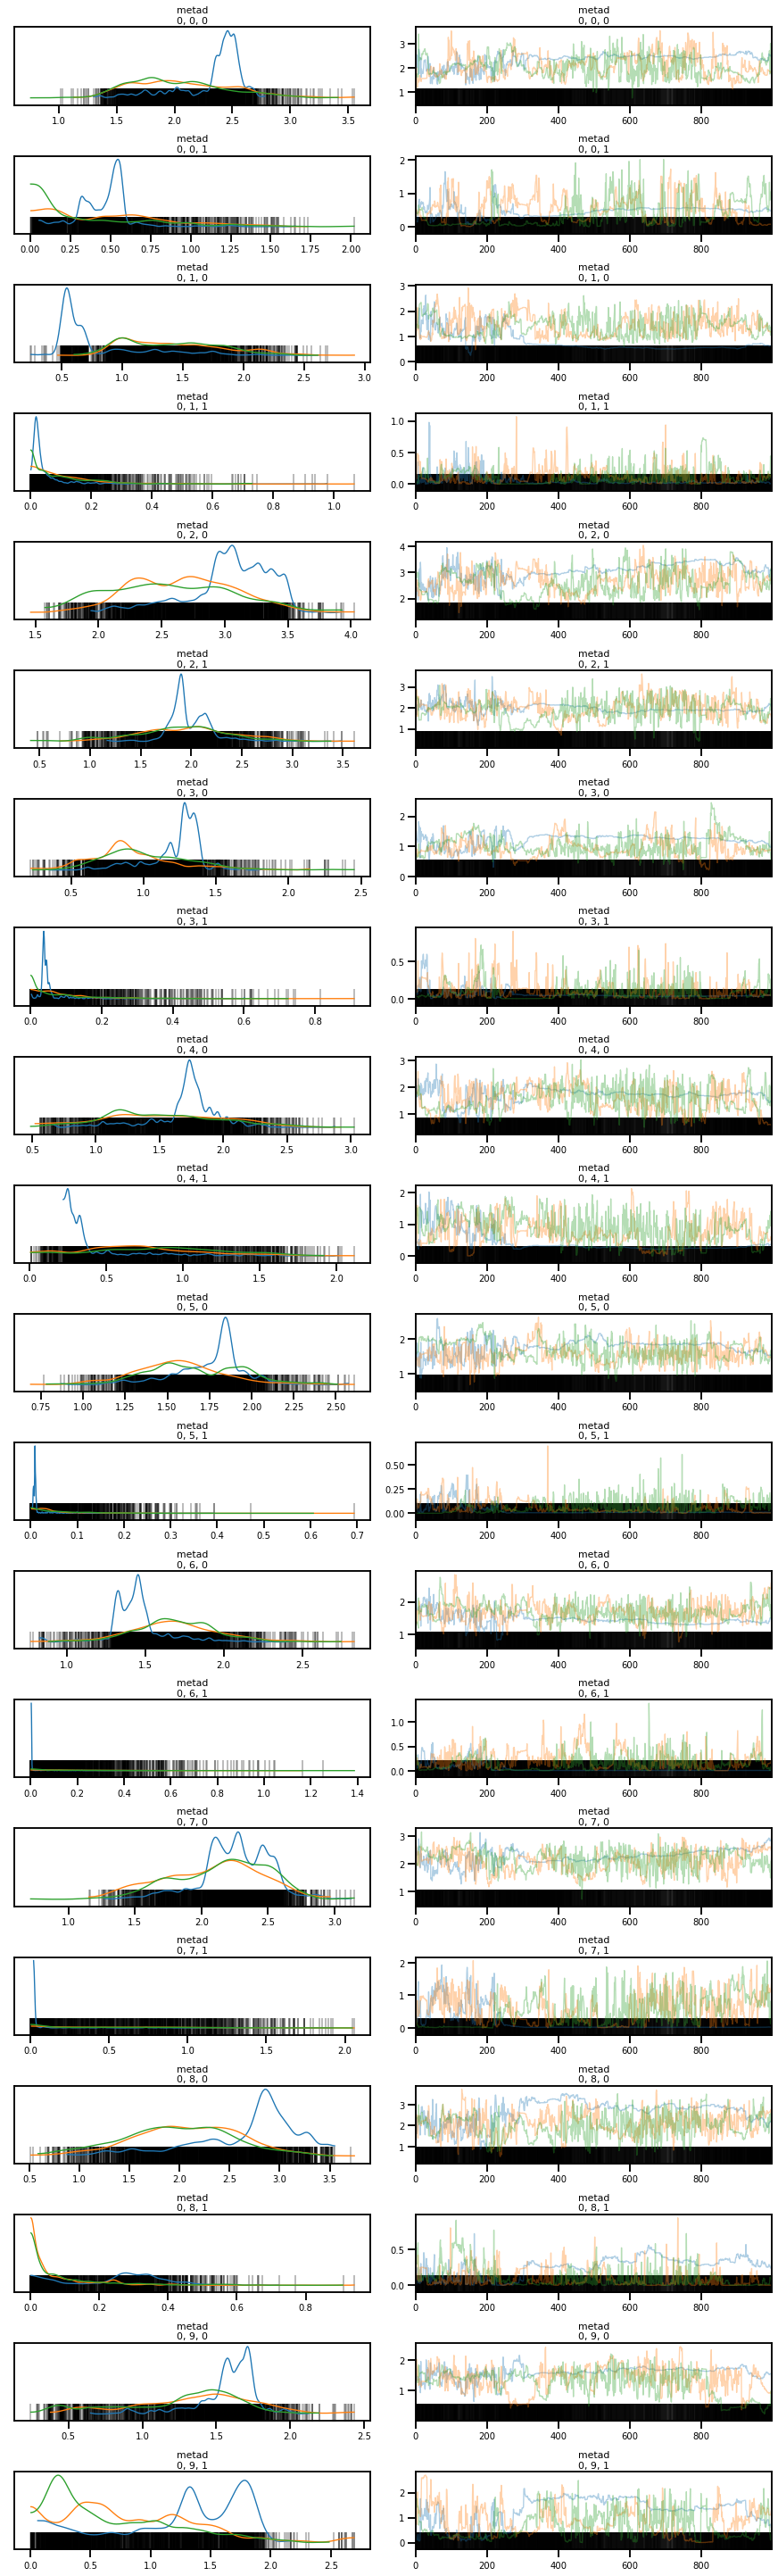

In [171]:
az.plot_trace(idata_pymc3, var_names=('metad'))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

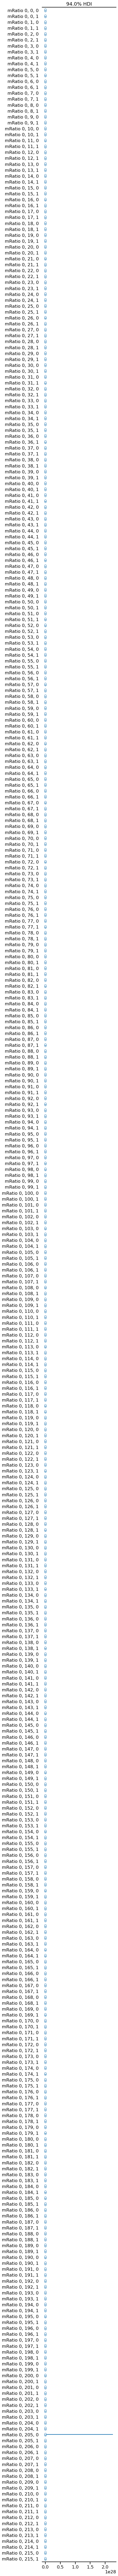

In [169]:
az.plot_forest(idata_pymc3, var_names=["mRatio"])

<AxesSubplot:xlabel='sigCond1', ylabel='mu_Cond1\n0'>

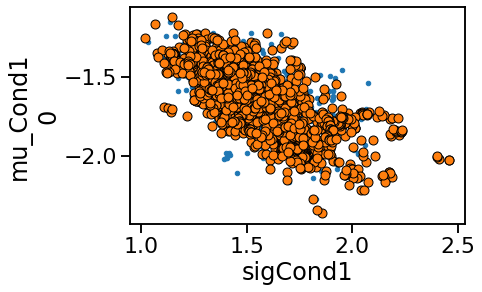

In [170]:
az.plot_pair(idata_pymc3, var_names=["sigCond1", "mu_Cond1"], divergences=True, textsize=22)